In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits
from tqdm import tqdm
import itertools

# Modified bessel function of the first kind
from scipy.special import iv
from scipy.optimize import curve_fit
import powerlaw
import lmfit

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory, discretizeTrajectoryIndices, autocorrelation, computeRotationalDiffusion, computeAngles, computePersistence

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

# First color is for uncropped, second for cropped
colors = ['tab:blue', 'tab:green']

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


# Load in data

In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-02-01.h5'
#dataFile = '/home/jack/Workspaces/data/ant_simulation/bounded_test_dataset_true.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 5 seconds.
minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████| 1434/1434 [00:01<00:00, 929.16it/s]

Loaded 424 segments!


In [3]:
padding = 15 # mm
inversePadding = None

noWallDataArr, noWallTimeArr, noWallMetadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|███████| 479/479 [00:58<00:00,  8.18it/s]

Loaded 838 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

# Discretize with singular representative parameters

In [4]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
# This corresponds to an angle of arccos(c)
cArr = [np.cos(np.pi/4)]

# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = [5] # mm/s

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 5 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)

noWallDiscreteDataArr = []
noWallDiscreteStepSizeArr = []
noWallWaitTimeArr = []
noWallRunTimeArr = []

for i in range(len(cArr)):
    noWallDiscreteDataArr.append([])
    noWallDiscreteStepSizeArr.append([])
    noWallWaitTimeArr.append([])
    noWallRunTimeArr.append([])

    for j in tqdm(range(len(noWallDataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(noWallDataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/noWallMetadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        noWallDiscreteDataArr[-1].append(discreteTraj)
        
        noWallDiscreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        noWallWaitTimeArr[-1].append(waitingTimes)
        noWallRunTimeArr[-1].append(runTimes)

  8%|███▌                                      | 36/424 [00:47<05:27,  1.18it/s]/home/jack/Workspaces/python/tracker/notebooks/../tracker/discretize.py:123: RuntimeWarning: invalid value encountered in divide
  absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))
100%|█████████████████████████████████████████| 838/838 [00:14<00:00, 56.80it/s]


# Discretize with many parameter choices

In [70]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
thetaArr = np.linspace(0.7, np.pi/2, 6)
cArr = np.cos(thetaArr)

# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = np.linspace(0, 10, 6)
# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 5 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

# No need to do the uncropped data since it takes a long time and
# we mostly care about fitting the cropped data.
# for i in range(len(cArr)):
#     discreteDataArr.append([])
#     discreteStepSizeArr.append([])
#     waitTimeArr.append([])
#     runTimeArr.append([])

#     for j in tqdm(range(len(dataArr))):
#         discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
#                                                                     c=cArr[i],
#                                                                     velocityThreshold=velocityThresholdArr[i],
#                                                                     dt=1/metadataArr[j]["fps"],
#                                                                     minSteps=minStepsPerRun,
#                                                                     minDistancePerRun=minDistancePerRun,
#                                                                     debug=False)
#         discreteDataArr[-1].append(discreteTraj)
        
#         discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
#         waitTimeArr[-1].append(waitingTimes)
#         runTimeArr[-1].append(runTimes)

noWallDiscreteDataArr = []
noWallDiscreteStepSizeArr = []
noWallWaitTimeArr = []
noWallRunTimeArr = []

for i in range(len(cArr)):
    noWallDiscreteDataArr.append([])
    noWallDiscreteStepSizeArr.append([])
    noWallWaitTimeArr.append([])
    noWallRunTimeArr.append([])

    for j in tqdm(range(len(noWallDataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(noWallDataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/noWallMetadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        noWallDiscreteDataArr[-1].append(discreteTraj)
        
        noWallDiscreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        noWallWaitTimeArr[-1].append(waitingTimes)
        noWallRunTimeArr[-1].append(runTimes)

100%|█████████████████████████████████████████| 842/842 [00:10<00:00, 78.16it/s]


# Compute angle changes

In [5]:
fps = metadataArr[0]["fps"]

angleArr = []
noWallAngleArr = []

for i in range(len(discreteDataArr)):
    angleArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteData = discreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        angleArr[-1].append(angles)

for i in range(len(noWallDiscreteDataArr)):
    noWallAngleArr.append([])

    for j in tqdm(range(len(noWallDataArr))):
        discreteData = noWallDiscreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        noWallAngleArr[-1].append(angles)

100%|██████████████████████████████████████| 838/838 [00:00<00:00, 12725.70it/s]


# Fit all quantities

The data we have has lots of structure, so it is worth explaining the different levels at which we are interested in fitting/averaging our trajectory statistics. 

(1) At the top level, we are interested in the total average (or median, or whatever) value for a certain statistic. This gives us an overview of
how all of the ants in the experiments act.

(2) One level below, we might be interested in the average value of a quantity for each individual ant. Of course we will have less data going into each value, but this can tell us something about how the behavior of these ants is distributed (as well as if it even makes sense to say that there is some well-defined "average" value).

(3) Finally, each individual ant's trajectory is broken down into segments; in the past, I computed quantities for each individual segment, and then took the median of those values, but this didn't work very well. The main issue is that each segment could contain only a few turns/runs/waits/etc., so fitting those to a distribution will give nonsensical results. A better way to do this is to pool all of the data from a single trial, and compute the median directly from that. For computing the quantities below, this is fine, though there is a reason I divide the trajectories into segments in the first place: we could not do this same pooling if we wanted to calculate a time-dependent quantity, eg. the MSD. We can only pool all of the segments under the assumption that the distribution of turns/runs/waits/etc. is stationary.

For fitting the rotational diffusion coefficient, there is even another level we need to consider, since the fitting for that quantity must be done within each straight run. These then need to be averaged over the whole segment, then the whole trial, then all trials.

In [6]:
# Exponential function that we use for fitting tau, Dr,
# and persistence time. Already normalized assuming xmin = 0
def exponential(x, x0, A):
    return np.exp(-x / x0) * A

# von Mises distribution that we use to fit sigma, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, k):
    """
    The von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    # We explicitly set the center of the distribution to zero
    return np.exp(k * np.cos(x)) / (2 * np.pi * iv(0, k))

# This is hardcoded to the arena size
arenaSize = np.array([200, 140]) - ((2*padding) if padding else 0) # in mm

# Minimum size of a run; values are chosen empirically, though the
# final results shouldn't depend too much on the exact values.
xMinRunTime = 1e-1 # [s]
# This is for fitting, though adding a max doesn't really
# change anything so I'll just leave it as None.
xMaxRunTime = None#np.linalg.norm(arenaSize)

# Minimum time; should be the smallest time we consider
# significant for a discretized run.
xMinWaitTime = 0.2
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

# For sigma fitting
numBins = 51

fps = metadataArr[0]["fps"]

# We store things based on the original trial they come
# from, so we can get the average (or median) value for each trial,
# plus the overall average. See comments above this cell.
trialMembership = np.array([m["dataset"] for m in noWallMetadataArr])
uniqueTrials = np.unique(trialMembership)
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))
# trialIndicesArr[i] gives the indices of all of the segments that belong to trial i
trialIndicesArr = [np.where(trialMembership == trial)[0] for trial in uniqueTrials]

# We can't compute persistence like we do for the above quantities (by pooling
# all segments from a trial) since this is an explicitly time-dependent quantity;
# we have to compute it within each segment and then take the median.
persistenceArr = [[] for _ in range(len(uniqueTrials))]

# Same indexing as above, except now arr[i,j] is a single value
# instead of a list of values for that trial.
meanVelocityArr = np.zeros((len(cArr), len(uniqueTrials)))
meanTauArr = np.zeros((len(cArr), len(uniqueTrials)))
meanSigmaArr = np.zeros((len(cArr), len(uniqueTrials)))
meanAlphaArr = np.zeros((len(cArr), len(uniqueTrials)))
meanDRArr = np.zeros((len(cArr), len(uniqueTrials)))
meanPersistenceArr = np.zeros(len(uniqueTrials))

# Velocity

# First for loops over discretization parameters
for i in tqdm(range(len(cArr))):
    # Second for loops over trials
    for j in range(len(uniqueTrials)):
        speed = []
        # Third for loops over segments in trials
        for k in trialIndicesArr[j]:        
            velocity = (noWallDataArr[k][1:] - noWallDataArr[k][:-1]) * fps
            speed += list(np.sqrt(np.sum(velocity**2, axis=-1)))

        # Remove low speeds; this is the part where the calculation depends
        # on the discretization parameters, though only very mildly.
        speed = np.array(speed)
        meanVelocityArr[i,j] = np.nanmedian(speed[speed > velocityThresholdArr[i]])
        
# Tau

# First for loops over discretization parameters
for i in tqdm(range(len(cArr))):
    # Second for loops over trials
    for j in range(len(uniqueTrials)):
        runSizes = []
        # Third for loops over segments in trials
        for k in trialIndicesArr[j]:        
            runSizes += list(noWallRunTimeArr[i][k])

        try:
            fit = powerlaw.Fit(runSizes, xmin=xMinRunTime, xmax=xMaxRunTime)

            # 1/lambda because powerlaw defines the exponential
            # as exp(-lambda x)
            meanTauArr[i,j] = 1 / fit.exponential.Lambda
        except:
            meanTauArr[i,j] = np.nan


# Sigma
bins = np.linspace(-np.pi, np.pi, numBins)

# First for loops over discretization parameters
for i in tqdm(range(len(cArr))):
    # Second for loops over trials
    for j in range(len(uniqueTrials)):
        angles = []
        # Third for loops over segments in trials
        for k in trialIndicesArr[j]:        
            angles += list(noWallAngleArr[i][k])

        if len(angles) <= 10:
            meanSigmaArr[i,j] = np.nan
            continue
            
        try:
            meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
            meanBins = (meanBins[1:] + meanBins[:-1]) / 2
    
            #plt.plot(meanBins, meanDist)
            #plt.show()
            pOpt, pCov = curve_fit(vonMises, meanBins, meanDist, p0=(1))
    
            # 15 is arbitrary, but just a (relatively) large value
            # We also should expect that the distribution is
            # centered, so if it is not (pOpt[0] is not zero), we should ignore the value since
            # it's probably just noise.
            if pOpt[0] <= 0 or (np.abs(pCov) > 15).any():# or np.abs(pOpt[0]) > 0.2:
                meanSigmaArr[i,j] = np.nan
                
            meanSigmaArr[i,j] = pOpt[0]
            
        except:
            meanSigmaArr[i,j] = np.nan


# Alpha

# First for loops over discretization parameters
for i in tqdm(range(len(cArr))):
    # Second for loops over trials
    for j in range(len(uniqueTrials)):
        waitTimes = []
        # Third for loops over segments in trials
        for k in trialIndicesArr[j]:        
            waitTimes += list(noWallWaitTimeArr[i][k])

        try:
            fit = powerlaw.Fit(waitTimes, xmin=xMinWaitTime, xmax=xMaxWaitTime)

            meanAlphaArr[i,j] = fit.power_law.alpha
            
        except:
            meanAlphaArr[i,j] = np.nan

# Dr
# This is a somewhat difficult calculation, or at least more so than the other
# parameters here. This is because we need to calculate Dr within each run,
# but often a single run doesn't have enough data to reliable do a fit, so
# we have to compute an autocorrelation pooling all of the runs in all of the
# segments BUT without introducing artifacts since each run should not be treated
# as continuing from the previous one.
# This is implemented in its own function because of this.

# First for loops over discretization parameters
for i in range(len(cArr)):
    # Second for loops over trials
    for j in tqdm(range(len(uniqueTrials))):

        segmentList = [noWallDataArr[k] for k in trialIndicesArr[j]]
        timeList = [noWallTimeArr[k] for k in trialIndicesArr[j]]
            
        Dr = computeRotationalDiffusion(segmentList,
                                        cArr[i], velocityThresholdArr[i], minStepsPerRun, minDistancePerRun,
                                        t=timeList, maxLag=0.5)
        meanDRArr[i,j] = Dr
        
# Persistence

# First for loops over trials
for j in tqdm(range(len(uniqueTrials))):
    
    segmentList = [noWallDataArr[k] for k in trialIndicesArr[j]]
    timeList = [noWallTimeArr[k] for k in trialIndicesArr[j]]

    persistence = computePersistence(segmentList, velocityThresholdArr[0],
                                     t=timeList, maxLag=0.5)
    meanPersistenceArr[j] = persistence
        
# Finally, we can calculate the overall mean values
# I originally did this using a weighted mean, but I think
# that is too sensitive to outliers, so instead I ended up
# just going with the regular median. You could also do a 
# weighted median, but not sure if that will make much of a
# difference.
meanVelocity = np.zeros(len(cArr))
meanTau = np.zeros(len(cArr))
meanSigma = np.zeros(len(cArr))
meanAlpha = np.zeros(len(cArr))
meanDR = np.zeros(len(cArr))

# totalWeight = np.zeros(len(uniqueTrials))
# for j in range(len(noWallDataArr)):
#     trialIndex = indexDict[noWallMetadataArr[j]["dataset"]]
#     totalWeight[trialIndex] += len(noWallDataArr[j])

for i in range(len(cArr)):

    # Velocity
#    goodIndices = np.where(~np.isnan(meanVelocityArr[i]))[0]
#    meanVelocity[i] = np.average(meanVelocityArr[i][goodIndices], weights=totalWeight[goodIndices])
    meanVelocity[i] = np.nanmedian(meanVelocityArr[i])
    
    # Tau
#    goodIndices = np.where(~np.isnan(meanTauArr[i]))[0]
#    meanTau[i] = np.average(meanTauArr[i][goodIndices], weights=totalWeight[goodIndices])
    meanTau[i] = np.nanmedian(meanTauArr[i])

    # Sigma
#    goodIndices = np.where(~np.isnan(meanSigmaArr[i]))[0]
#    meanSigma[i] = np.average(meanSigmaArr[i][goodIndices], weights=totalWeight[goodIndices])
    meanSigma[i] = np.nanmedian(meanSigmaArr[i])

    # Alpha
#    goodIndices = np.where(~np.isnan(meanAlphaArr[i]))[0]
#    meanAlpha[i] = np.average(meanAlphaArr[i][goodIndices], weights=totalWeight[goodIndices])
    meanAlpha[i] = np.nanmedian(meanAlphaArr[i])

    # Dr
#    goodIndices = np.where(~np.isnan(meanDRArr[i]))[0]
#    meanDR[i] = np.average(meanDRArr[i][goodIndices], weights=totalWeight[goodIndices])
    meanDR[i] = np.nanmedian(meanDRArr[i])

# Persistence
#goodIndices = np.where(~np.isnan(meanPersistenceArr))[0]
#meanPersistence = np.average(meanPersistenceArr[goodIndices], weights=totalWeight[goodIndices])
meanPersistence = np.nanmedian(meanPersistenceArr)

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/powerlaw/fitting.py:270: UserWarning: Values less than or equal to 0 in data. Throwing out 0 or negative values.
  warnings.warn("Values less than or equal to 0 in data. Throwing out 0 or negative values.")
  0%|                                                    | 0/81 [00:00<?, ?it/s]/home/jack/Workspaces/python/tracker/notebooks/../tracker/analysis.py:276: OptimizeWarning: Covariance of the parameters could not be estimated
  pOpt, pCov, info, mesg, success = curve_fit(exponential, tArr, autocorrArr,
100%|███████████████████████████████████████████| 81/81 [00:05<00:00, 13.85it/s]


In [7]:
meanVelocity, meanTau, meanSigma, meanAlpha, meanDR, meanPersistence

(array([16.2739563]),
 array([1.27014096]),
 array([1.01390637]),
 array([1.64085019]),
 array([0.10149257]),
 1.65663143167248)

# Plotting

## Plot turn angle distribution

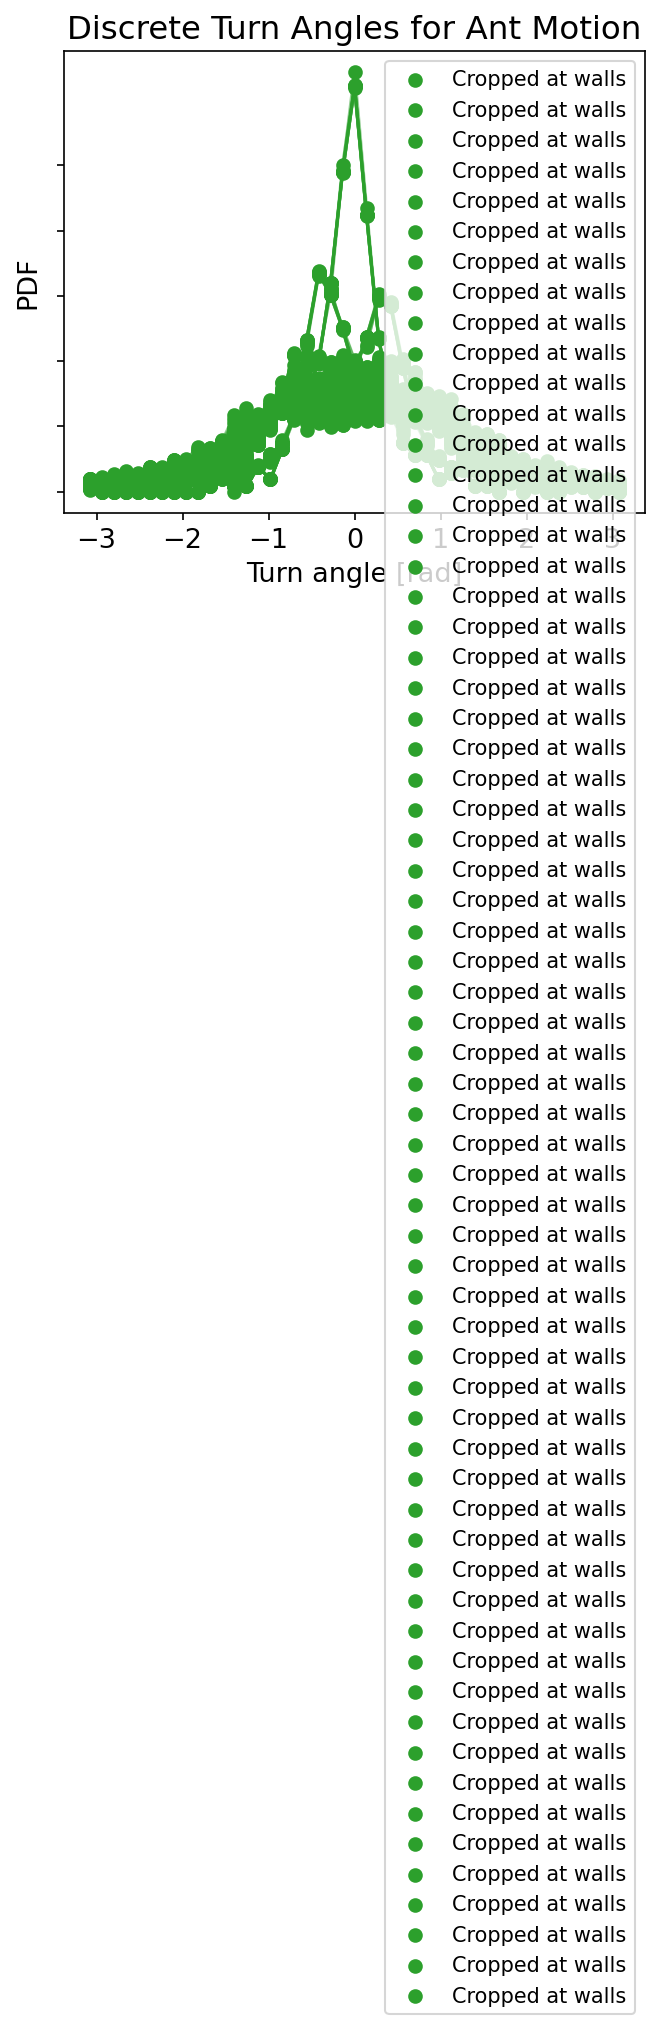

In [48]:
numBins = 45

bins = np.linspace(-np.pi, np.pi, numBins+1)
#bins = np.logspace(-1, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in angleArr[i] for a in aa])
    noWallAngles = np.array([a for aa in noWallAngleArr[i] for a in aa])

    #angles[angles == 0] = np.nan
    
#    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist, c=colors[0], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
#    plt.scatter(binArr, meanDist, c=colors[0], label=f'Uncropped', marker='s')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
#    plt.plot(binArr, meanDist, '-', alpha=0.5, c=colors[0])
    
#    meanDist, meanBins = np.histogram(noWallAngles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist - 0.5, c=colors[1], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
#    plt.scatter(binArr, meanDist - 0.5, c=colors[1], label=f'Cropped at walls')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
#    plt.plot(binArr, meanDist - 0.5, '-', alpha=0.5, c=colors[1])
    
k = 0.8
#plt.plot(binArr, 1/k/10 * np.exp(k * np.cos(binArr)) - 0.5, '--', c='tab:green')

#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.yticks(np.linspace(-0.5, 0.6, 6), ['']*6)
plt.xlabel('Turn angle [rad]')
plt.legend(fontsize=10)
#plt.title('Discrete Turn Angle Distribution for Ant Motion\nUncropped')
plt.title('Discrete Turn Angles for Ant Motion')
plt.gcf().set_size_inches((5,4))
#pltsaveall('08_DiscreteTurnAngle_Cropped')
plt.show()

## Fitting turn angle distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


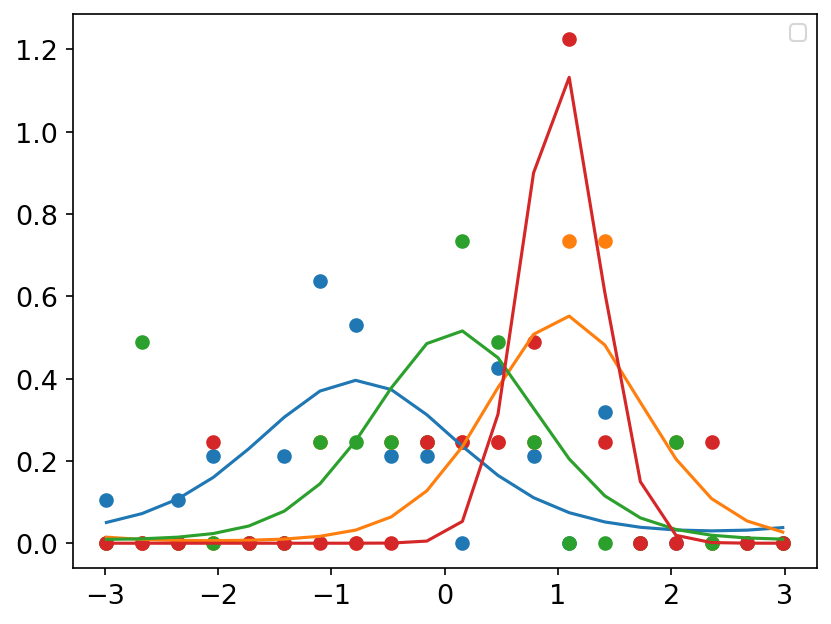

In [219]:
# We use a von mises distribution to fit, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, mu, k):
    """
    The Von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    return np.exp(k * np.cos(x - mu)) / (2 * np.pi * iv(0, k))
    
sigmaArr = []

# For sigma fitting
numBins = 20
bins = np.linspace(-np.pi, np.pi, numBins+1)

for i in range(len(cArr)):
    for j in range(len(noWallAngleArr[i]))[:10]:
        angles = noWallAngleArr[i][j]

        angles = angles[~np.isnan(angles)]
        if len(angles) <= 10:
            continue
            
        meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
        meanBins = (meanBins[1:] + meanBins[:-1]) / 2
        
        pOpt, pCov = curve_fit(vonMises, meanBins, meanDist, p0=(0, 1))

        sigmaArr.append(pOpt[1])
        plt.plot(meanBins, vonMises(meanBins, pOpt[0], pOpt[1]))
        plt.scatter(meanBins, meanDist)#, label=f'$\\sigma = {metadataArr[0]["angleSigma"]}$, $\\hat \\sigma = {pOpt[1]:.3}$', alpha=0.3)

plt.legend(fontsize=10)
#plt.yscale('log')
plt.show()

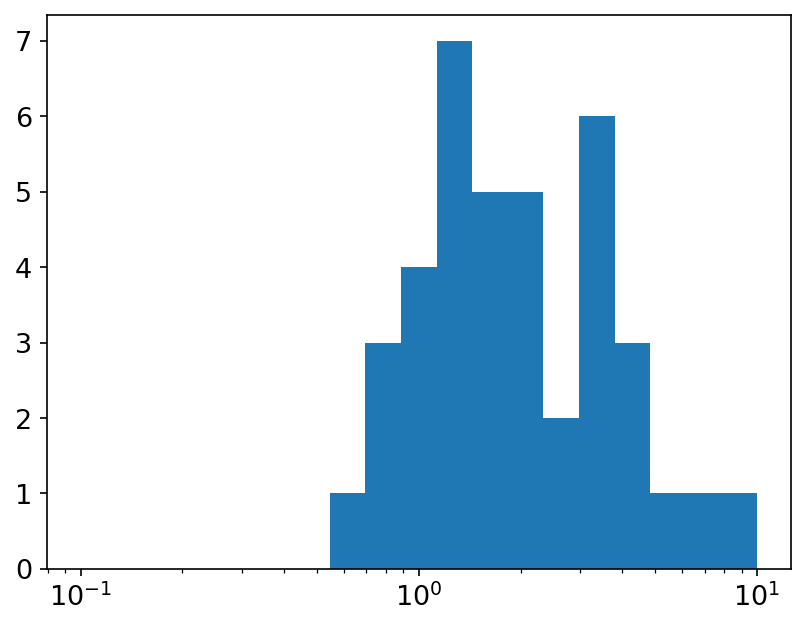

In [151]:
plt.hist(sigmaArr, bins=np.logspace(-1, 1, 20))
plt.xscale('log')
plt.show()

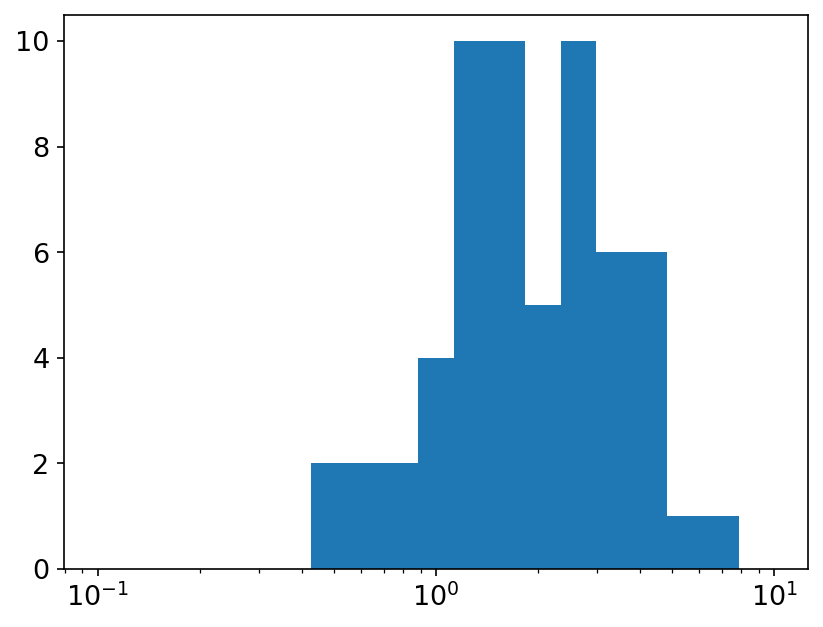

In [156]:
plt.hist(meanSigmaArr[0], bins=np.logspace(-1, 1, 20))
plt.xscale('log')
plt.show()

In [158]:
np.nanmedian(meanSigmaArr[0])

1.8068345682333784

## Plot run time distribution

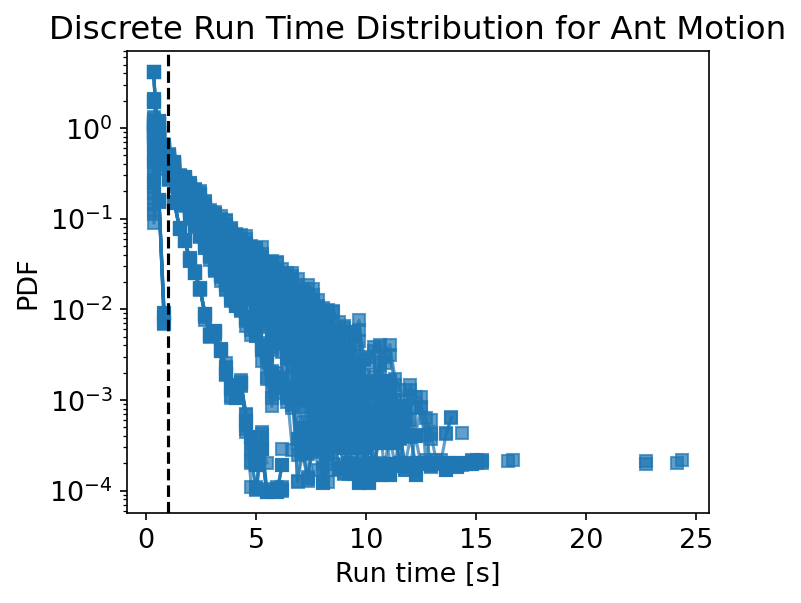

In [44]:
# Minimum time; just a reasonable (empirical) value
xMin = 1 # [s]
# Maximum time
xMax = None

fig, ax = plt.subplots()

for i in range(len(cArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax, color=colors[0], marker='s', label=f'Uncropped', alpha=0.7)

#    runTimes = np.array([t for rt in noWallRunTimeArr[i] for t in rt])
#    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax, color=colors[1], marker='o', label=f'Cropped at walls', alpha=0.7)

plt.axvline(xMin, linestyle='--', c='black')
#plt.axvline(xMax, linestyle='--', c='black')

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run time [s]')
#plt.legend(fontsize=10)
#plt.title('Discrete Run Time Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Time Distribution for Ant Motion')
fig.set_size_inches((5,4))
#pltsaveall('12_DiscreteRunTime_Cropped')
plt.show()

## Plot wait time distribution

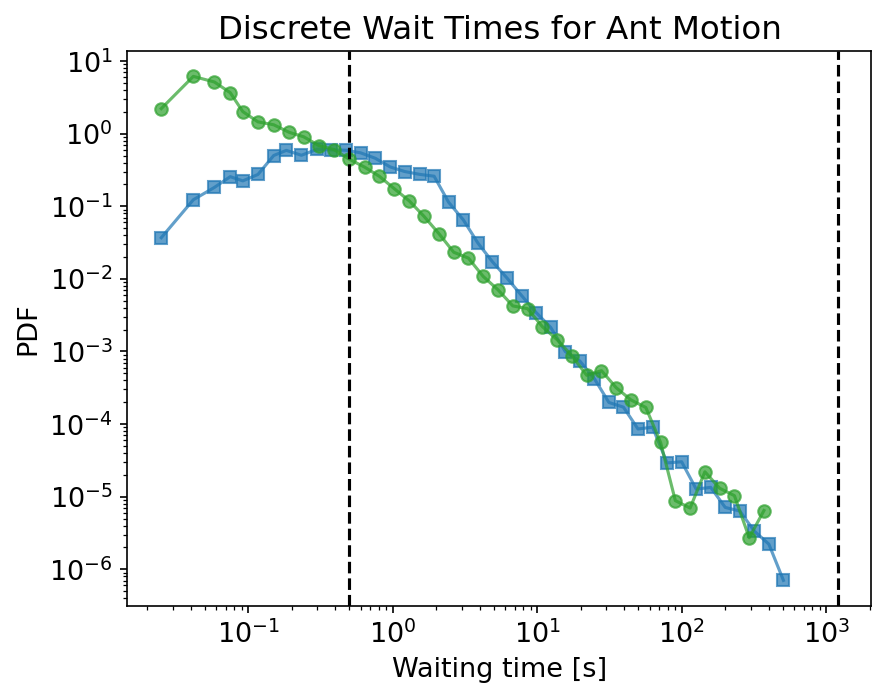

In [23]:
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMin = maximumTimeSkip / metadataArr[0]["fps"] * 3
# Maximum time should be the length of a trial
xMax = 1200 # [s], 20 minutes

#colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.BASE_COLORS)

fig, ax = plt.subplots()
alphaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax, color=colors[0], label=f'Uncropped', marker='s', alpha=0.7)
    
    waitTimes = np.array([t for wt in noWallWaitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax, color=colors[1], label=f'Cropped at walls', marker='o', alpha=0.7)

plt.axvline(xMin, c='black', linestyle='--')
plt.axvline(xMax, c='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Waiting time [s]')
#plt.legend(fontsize=10)
plt.title('Discrete Wait Times for Ant Motion')
plt.show()

## Plot persistence time

Median direct fit persistence time: 0.6885411872921712 seconds
Median discrete fit persistence time: 1.9998548457433853 seconds
Median discrete fit persistence time: 1.8919922099558368 seconds
Median discrete fit persistence time: 1.9531882965759215 seconds
Median discrete fit persistence time: 1.9818665028508216 seconds
Median discrete fit persistence time: 1.958977804227104 seconds
Median discrete fit persistence time: 1.9720777996842216 seconds
Median discrete fit persistence time: 1.9580303125114673 seconds
Median discrete fit persistence time: 1.8667244771346212 seconds
Median discrete fit persistence time: 1.8000410596372274 seconds
Median discrete fit persistence time: 1.789090772839609 seconds
Median discrete fit persistence time: 1.8104985277020975 seconds
Median discrete fit persistence time: 1.8913451472583485 seconds
Median discrete fit persistence time: 1.7923348889530437 seconds
Median discrete fit persistence time: 1.8114060122026943 seconds
Median discrete fit persisten

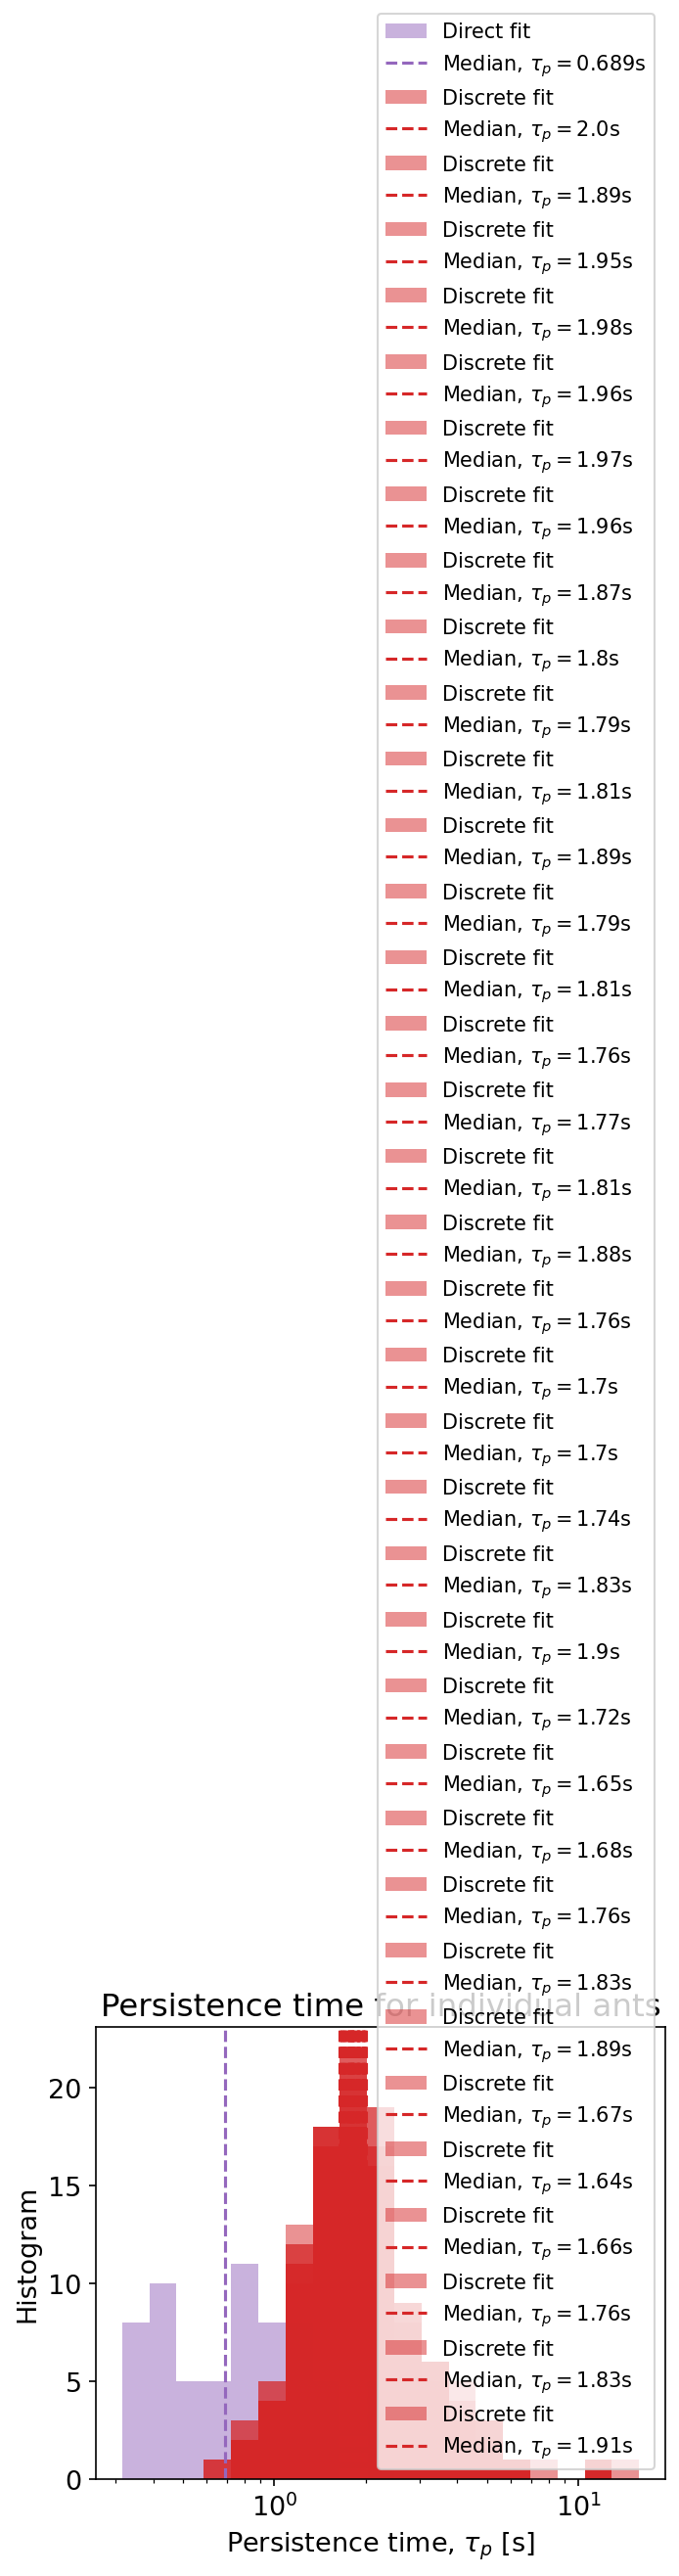

In [76]:
plt.hist(meanPersistenceArr, bins=np.logspace(-0.5, 1.2, 20), density=False, alpha=0.5, color='tab:purple', label='Direct fit')
directFitLN = powerlaw.Lognormal(data=meanPersistenceArr, xmin=1e-2)
#directFitLN.plot_pdf(color='tab:blue', label=f'Lognormal, $e^\\mu = {np.exp(directFitLN.mu):.3}$s')
plt.axvline(meanPersistence, linestyle='--', color='tab:purple', label=f'Median, $\\tau_p = {meanPersistence:.3}$s')

print(f'Median direct fit persistence time: {np.nanmedian(meanPersistenceArr)} seconds')

for i in range(len(cArr)):
    
    # plt.hist(meanTauArr, bins=np.logspace(-1.5, 2, 20), density=False, alpha=0.5, label='Tau')
    # plt.axvline(np.nanmedian(meanTauArr), linestyle='--', color='green', label='Tau')
    
    theoreticalPersistence = 1 / (meanDRArr[i] + 1/meanTauArr[i] * (1 - iv(1, meanSigmaArr[i]) / iv(0, meanSigmaArr[i])))
    
    plt.hist(theoreticalPersistence, bins=np.logspace(-0.5, 1.2, 20), density=False, alpha=0.5, color='tab:red', label='Discrete fit')
#    discreteFitLN = powerlaw.Lognormal(data=theoreticalPersistence, xmin=1e-2)
#    discreteFitLN.plot_pdf(color='tab:orange', label=f'Lognormal, $e^\\mu = {np.exp(discreteFitLN.mu):.3}$s')

    plt.axvline(np.nanmedian(theoreticalPersistence), linestyle='--', color='tab:red', label=f'Median, $\\tau_p = {np.nanmedian(theoreticalPersistence):.3}$s')

    print(f'Median discrete fit persistence time: {np.nanmedian(theoreticalPersistence)} seconds')


#    medianTheoreticalPersistence = 1 / (meanDR[i] + 1/meanTau[i] * (1 - iv(1, meanSigma[i]) / iv(0, meanSigma[i])))
#    plt.axvline(medianTheoreticalPersistence, linestyle='--', color='black', label=f'Median, $\\tau_p = {medianTheoreticalPersistence}$s')

plt.xscale('log')
#plt.ylim([0.8e-2, 1.2e0])
plt.yticks([0, 5, 10, 15, 20])
plt.legend(fontsize=10)
plt.xlabel('Persistence time, $\\tau_p$ [s]')
plt.ylabel('Histogram')
plt.title('Persistence time for individual ants')
plt.gcf().set_size_inches((5,4))
#plt.savefig('persistence_time.pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


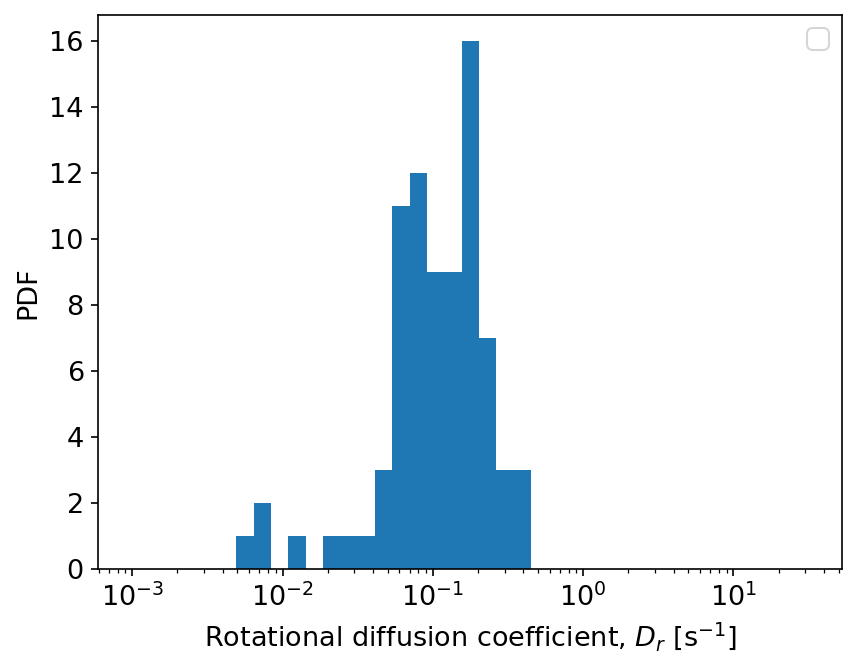

In [37]:
data = meanDRArr[0]
plt.hist(data, bins=np.logspace(-3, 1.5, 40))
plt.xscale('log')
#plt.hist(data, bins=np.linspace(0, 3, 100), density=True)
#powerlaw.plot_pdf(data=data, marker='o')
#powerlaw.Lognormal(data=data, xmin=1e-2).plot_pdf(label='Lognormal fit')
#powerlaw.Stretched_Exponential(data=data, xmin=1e-2).plot_pdf
plt.xlabel('Rotational diffusion coefficient, $D_r$ [s$^{-1}$]')
plt.ylabel('PDF')
plt.legend()
plt.show()

## Plot run times, wait times, and turn angles

In [10]:
# We use a von mises distribution to fit, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, mu, k):
    """
    The von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    return np.exp(k * np.cos(x - mu)) / (2 * np.pi * iv(0, k))
    
sigmaArr = np.zeros((len(cArr)))

numAngleBins = 45
angleBins = np.linspace(-np.pi, np.pi, numAngleBins+1)
# The centers of the bins used for plotting or fitting
angleBinArr = (angleBins[1:] + angleBins[:-1])/2

for i in range(len(angleArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in noWallAngleArr[i] for a in aa])
    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=angleBins, density=True)
    meanBins = (meanBins[1:] + meanBins[:-1]) / 2
    
    pOpt, pCov = curve_fit(vonMises, meanBins, meanDist, p0=(0, 1))

    sigmaArr[i] = pOpt[1] 

# For run times
# Minimum time; just a reasonable (empirical) value
xMinRunTime = 1 # [s]
# Maximum time
xMaxRunTime = None

lambdaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(noWallDiscreteStepSizeArr)):
    # The if t part removes zero values (which probably shouldn't be there
    # in the first place...)
    runTimes = np.array([t for rt in noWallRunTimeArr[i] for t in rt if t])

    try:
        fit = powerlaw.Fit(runTimes, xmin=xMinRunTime, xmax=xMaxRunTime)
        lambdaArr[i] = fit.exponential.Lambda
        
    except:
        lambdaArr[i] = np.nan

# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMinWaitTime = 0.5
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

alphaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    waitTimes = np.array([t for wt in noWallWaitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMinWaitTime, xmax=xMaxWaitTime)

    alphaArr[i] = fit.power_law.alpha

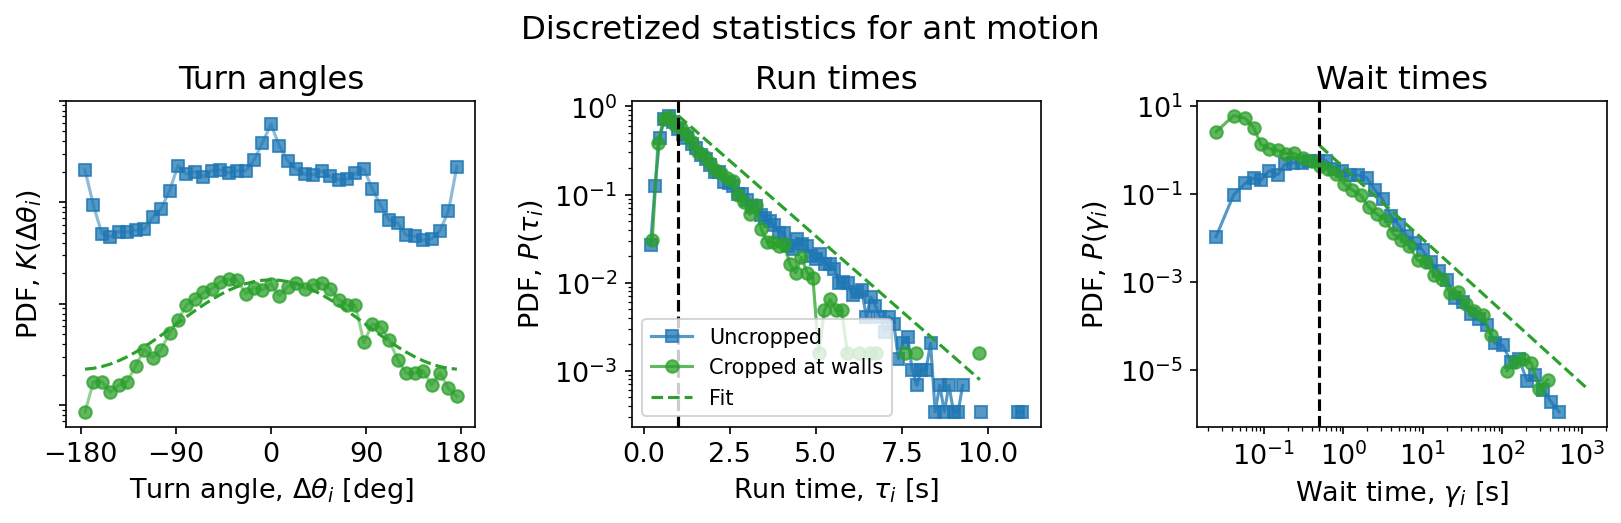

In [8]:
# For angles
numBins = 45
bins = np.linspace(-np.pi, np.pi, numBins+1)
binArr = (bins[1:] + bins[:-1])/2

# For run times
# Minimum time; just a reasonable (empirical) value
xMinRunTime = 1 # [s]
# Maximum time
xMaxRunTime = None

# For waiting times
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMinWaitTime = maximumTimeSkip / metadataArr[0]["fps"] * 3
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

fig, ax = plt.subplots(1, 3, figsize=(11,3.75))

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in angleArr[i] for a in aa])
    noWallAngles = np.array([a for aa in noWallAngleArr[i] for a in aa])

    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist, c=colors[0], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].scatter(binArr*180/np.pi, meanDist, c=colors[0], label=f'Uncropped' if i == 0 else None, marker='s', alpha=0.75)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].plot(binArr*180/np.pi, meanDist, '-', alpha=0.5, c=colors[0])
    
    meanDist, meanBins = np.histogram(noWallAngles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist - 0.5, c=colors[1], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].scatter(binArr*180/np.pi, meanDist * 5e-2, c=colors[1], label=f'Cropped at walls' if i == 0 else None, alpha=0.75)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].plot(binArr*180/np.pi, meanDist * 5e-2, '-', alpha=0.5, c=colors[1])

    ax[0].plot(binArr*180/np.pi, vonMises(binArr, meanSigma[i]) * 5e-2, '--', color=colors[1], label='Fit')
    
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax[1], color=colors[0], marker='s', label=f'Uncropped', alpha=0.75)

    runTimes = np.array([t for rt in noWallRunTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax[1], color=colors[1], marker='o', label=f'Cropped at walls', alpha=0.75)
    
    powerlaw.Exponential(xmin=xMinRunTime, xmax=np.max(runTimes), Lambda=1/meanTau[i]).plot_pdf(ax=ax[1], color=colors[1], linestyle='--', label='Fit')

    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax[2], color=colors[0], label=f'Uncropped', marker='s', alpha=0.75)
    
    waitTimes = np.array([t for wt in noWallWaitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax[2], color=colors[1], label=f'Cropped at walls', marker='o', alpha=0.75)
    powerlaw.Power_Law(xmin=xMinWaitTime, xmax=xMaxWaitTime, alpha=meanAlpha[i]).plot_pdf(ax=ax[2], color=colors[1], linestyle='--', label='Fit')

k = 0.8

ax[0].set_yscale('log')
ax[0].relim()
#plt.xscale('log')
ax[0].set_yticks([1e-3, 1e-2, 1e-1, 1e0], labels=['']*4)
ax[0].set_ylabel('PDF, $K(\\Delta \\theta_i)$')
#ax[0,0].set_yticks(np.linspace(-0.5, 0.6, 6), ['']*6)
ax[0].set_xticks([-180, -90, 0, 90, 180])
ax[0].set_xlabel('Turn angle, $\\Delta \\theta_i$ [deg]')
#ax[0].legend(fontsize=10)
ax[0].set_title('Turn angles')

ax[1].axvline(xMinRunTime, c='black', linestyle='--')
#ax[1].axvline(xMaxRunTime, c='black', linestyle='--')

ax[1].set_yscale('log')
ax[1].set_xscale('linear')
ax[1].set_ylabel('PDF, $P(\\tau_i)$')
ax[1].set_xlabel('Run time, $\\tau_i$ [s]')
ax[1].legend(fontsize=10)
ax[1].set_title('Run times')

ax[2].axvline(xMinWaitTime, c='black', linestyle='--')
#ax[2].axvline(xMaxWaitTime, c='black', linestyle='--')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel('PDF, $P(\\gamma_i)$')
ax[2].set_xlabel('Wait time, $\\gamma_i$ [s]')
#plt.legend(fontsize=10)
ax[2].set_title('Wait times')

fig.suptitle('Discretized statistics for ant motion', y=0.93)
fig.tight_layout()
plt.savefig('discretized_statistics.pdf')
plt.show()

In [9]:
meanSigma, meanTau, meanAlpha, meanDR, meanVelocity

(array([1.01390637]),
 array([1.27014096]),
 array([1.64085019]),
 array([0.10149257]),
 array([16.2739563]))

In [26]:
1 / (0.07 + 1/1.2 * (1 - iv(1, 0.8) / iv(0, 0.8)))

1.6832070702855642

## Overview figure with fitting

In [9]:
# Convert to discrete steps
fps = metadataArr[0]["fps"]

angleArr = []
noWallAngleArr = []

for i in range(len(cArr)):
    angleArr.append([])
    noWallAngleArr.append([])

    # for j in tqdm(range(len(dataArr))):
    #     discreteData = discreteDataArr[i][j] 

    #     angles = computeAngles(discreteData,
    #                            dt=1/fps,
    #                            minVelocityThreshold=velocityThresholdArr[i])

    #     angleArr[-1].append(angles)

    for j in tqdm(range(len(noWallDataArr))):
        discreteData = noWallDiscreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        noWallAngleArr[-1].append(angles)

100%|██████████████████████████████████████| 842/842 [00:00<00:00, 12603.96it/s]


In [364]:
# We use a von mises distribution to fit, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, mu, k):
    """
    The von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    return np.exp(k * np.cos(x - mu)) / (2 * np.pi * iv(0, k))
    
sigmaArr = np.zeros((len(cArr)))

for i in range(len(noWallAngleArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in noWallAngleArr[i] for a in aa])
    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
    meanBins = (meanBins[1:] + meanBins[:-1]) / 2
    
    pOpt, pCov = curve_fit(vonMises, meanBins, meanDist, p0=(0, 1))

    sigmaArr[i] = pOpt[1] 

# For run times
# Minimum time; just a reasonable (empirical) value
xMinRunTime = 1 # [s]
# Maximum time
xMaxRunTime = None

lambdaArr = np.zeros(len(noWallDiscreteStepSizeArr))

for i in range(len(noWallDiscreteStepSizeArr)):
    runTimes = np.array([t for rt in noWallRunTimeArr[i] for t in rt])

    try:
        fit = powerlaw.Fit(runTimes, xmin=xMinRunTime, xmax=xMaxRunTime)
        lambdaArr[i] = 1 / fit.exponential.Lambda
        
    except:
        lambdaArr[i] = np.nan

# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMinWaitTime = 0.5
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

alphaArr = np.zeros(len(noWallWaitTimeArr))

for i in range(len(noWallWaitTimeArr)):
    waitTimes = np.array([t for wt in noWallWaitTimeArr[i] for t in wt])

    fit = powerlaw.Fit(waitTimes, xmin=xMinWaitTime, xmax=xMaxWaitTime)

    alphaArr[i] = fit.power_law.alpha

/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/powerlaw/fitting.py:264: UserWarning: Values less than or equal to 0 in data. Throwing out 0 or negative values.
  warnings.warn("Values less than or equal to 0 in data. Throwing out 0 or negative values.")


/tmp/ipykernel_180327/310995264.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0,0].scatter(binArr*180/np.pi, meanDist, c=colormaps[0](norms[0](meanSigma[i])), alpha=0.5)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')


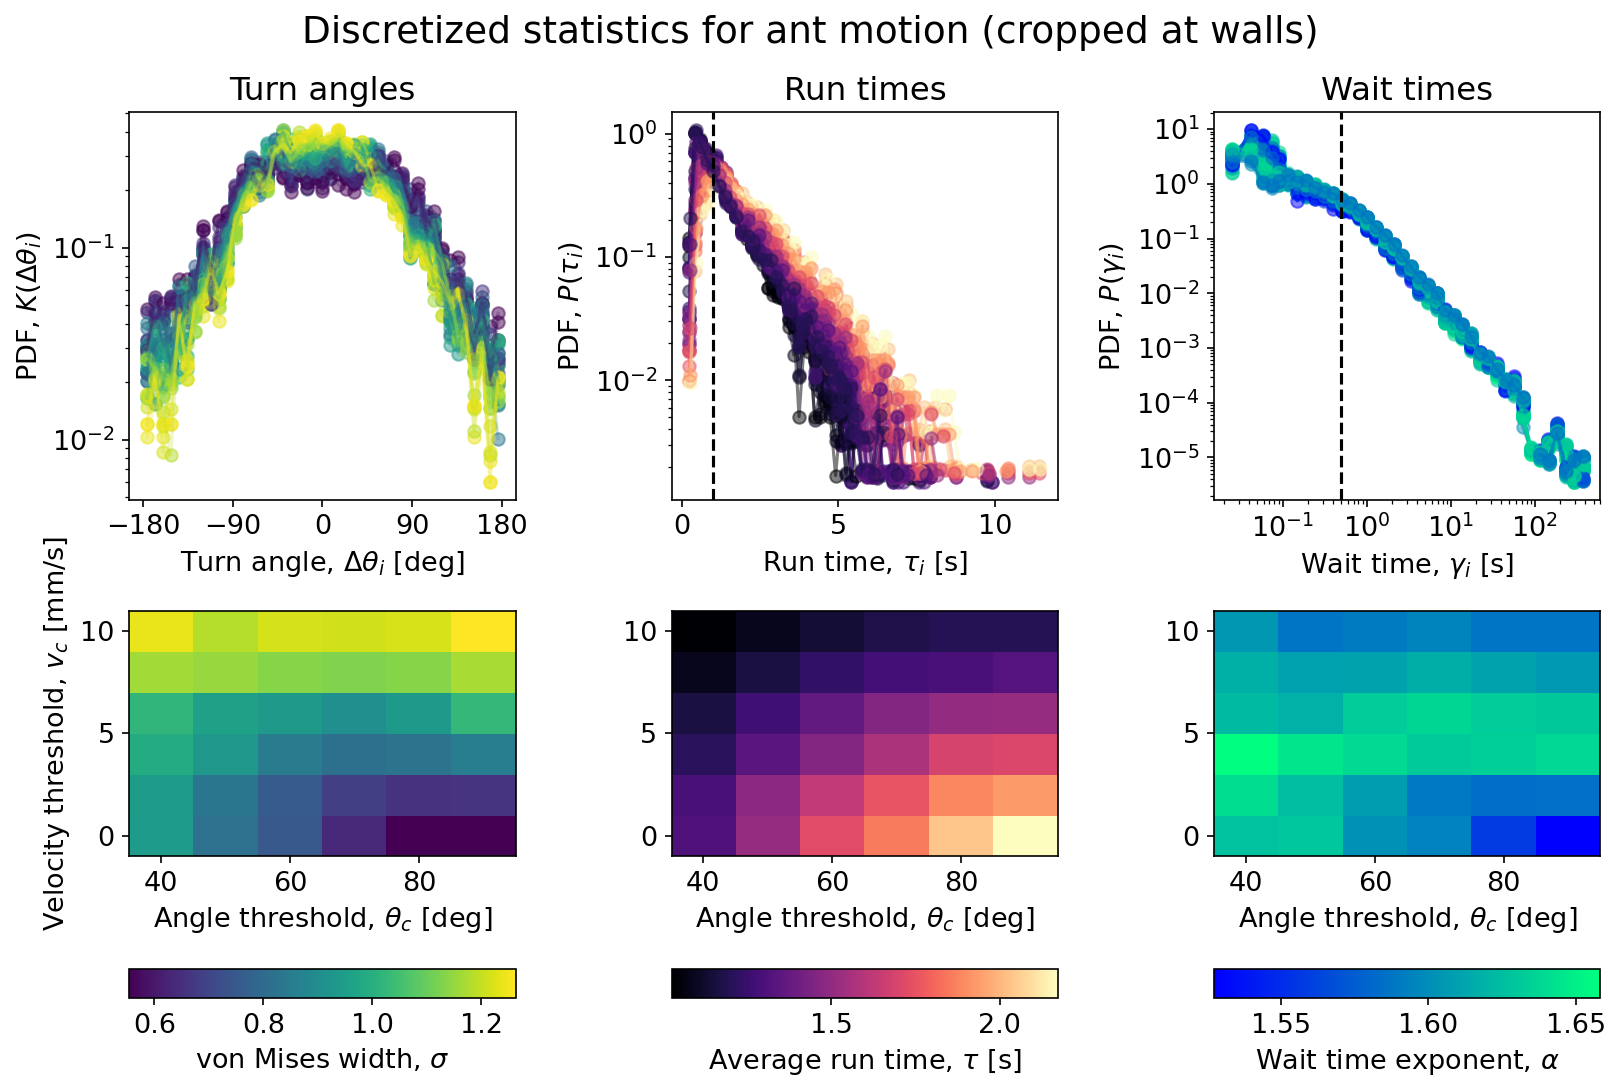

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

colormaps = ['viridis', 'magma', 'winter']
colormaps = [plt.get_cmap(c) for c in colormaps]

norms = [mpl.colors.Normalize(vmin=np.min(meanSigma), vmax=np.max(meanSigma)),
         mpl.colors.Normalize(vmin=np.min(meanTau), vmax=np.max(meanTau)),
         mpl.colors.Normalize(vmin=np.min(meanAlpha), vmax=np.max(meanAlpha))]

# For angles
numBins = 45
bins = np.linspace(-np.pi, np.pi, numBins+1)
binArr = (bins[1:] + bins[:-1])/2

# For run times
# Minimum time; just a reasonable (empirical) value
xMinRunTime = 1 # [s]
# Maximum time
xMaxRunTime = None

# For waiting times
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMinWaitTime = maximumTimeSkip / metadataArr[0]["fps"] * 3
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

fig, ax = plt.subplots(2, 3, figsize=(11,7.5))

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    #angles = np.array([a for aa in angleArr[i] for a in aa])
    noWallAngles = np.array([a for aa in noWallAngleArr[i] for a in aa])
    meanDist, meanBins = np.histogram(noWallAngles, bins=bins, density=True)
    
    ax[0,0].scatter(binArr*180/np.pi, meanDist, c=colormaps[0](norms[0](meanSigma[i])), alpha=0.5)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0,0].plot(binArr*180/np.pi, meanDist, '-', alpha=0.25, c=colormaps[0](norms[0](meanSigma[i])))

    runTimes = np.array([t for rt in noWallRunTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax[0,1], color=colormaps[1](norms[1](meanTau[i])), marker='o', label=f'Cropped at walls', alpha=0.5)

    waitTimes = np.array([t for wt in noWallWaitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax[0,2], color=colormaps[2](norms[2](meanAlpha[i])), label=f'Cropped at walls', marker='o', alpha=0.5)

ax[0,0].set_yscale('log')
#plt.xscale('log')
ax[0,0].set_ylabel('PDF, $K(\\Delta \\theta_i)$')
#ax[0,0].set_yticks(np.linspace(-0.5, 0.6, 6), ['']*6)
ax[0,0].set_xticks([-180, -90, 0, 90, 180])
ax[0,0].set_xlabel('Turn angle, $\\Delta \\theta_i$ [deg]')
#ax[0,0].legend(fontsize=10)
ax[0,0].set_title('Turn angles')

ax[0,1].axvline(xMinRunTime, c='black', linestyle='--')
#ax[1].axvline(xMaxRunTime, c='black', linestyle='--')

ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('PDF, $P(\\tau_i)$')
ax[0,1].set_xlabel('Run time, $\\tau_i$ [s]')
#plt.legend(fontsize=10)
ax[0,1].set_title('Run times')

ax[0,2].axvline(xMinWaitTime, c='black', linestyle='--')
#ax[0,2].axvline(xMaxWaitTime, c='black', linestyle='--')
ax[0,2].set_yscale('log')
ax[0,2].set_xscale('log')
ax[0,2].set_ylabel('PDF, $P(\\gamma_i)$')
ax[0,2].set_xlabel('Wait time, $\\gamma_i$ [s]')
#plt.legend(fontsize=10)
ax[0,2].set_title('Wait times')


# Now the fitting plots
cax = []
for i in range(3):
    divider = make_axes_locatable(ax[1,i])
    cax.append(divider.append_axes("bottom", size="12%", pad=0.75))
       
uniqueThetaArr = np.unique(thetaArr) * 180 / np.pi
uniqueVArr = np.unique(velocityThresholdArr)

sigmaMatrix = meanSigma.reshape((len(uniqueThetaArr), len(uniqueVArr)))

pc = ax[1,0].pcolor(uniqueThetaArr, uniqueVArr, sigmaMatrix.T, cmap=colormaps[0], rasterized=True)
fig.colorbar(pc, orientation='horizontal', label='von Mises width, $\\sigma$', cax=cax[0])
#ax[1,0].set_xticks([0, 10, 20, 30, 40])
#ax[1,0].set_yticks(uniqueVArr)
ax[1,0].set_xlabel('Angle threshold, $\\theta_c$ [deg]')
ax[1,0].set_ylabel('Velocity threshold, $v_c$ [mm/s]')

tauMatrix = meanTau.reshape((len(uniqueThetaArr), len(uniqueVArr)))

pc = ax[1,1].pcolor(uniqueThetaArr, uniqueVArr, tauMatrix.T, cmap=colormaps[1], rasterized=True)
fig.colorbar(pc, orientation='horizontal', label='Average run time, $\\tau$ [s]', cax=cax[1])
#ax[1,1].set_xticks([0, 10, 20, 30, 40])
#ax[1,1].set_yticks(uniqueVArr)
ax[1,1].set_xlabel('Angle threshold, $\\theta_c$ [deg]')
#ax[1,1].set_ylabel('Velocity threshold, $v_c$ [mm/s]')

alphaMatrix = meanAlpha.reshape((len(uniqueThetaArr), len(uniqueVArr)))

pc = ax[1,2].pcolor(uniqueThetaArr, uniqueVArr, alphaMatrix.T, cmap=colormaps[2], rasterized=True)
fig.colorbar(pc, orientation='horizontal', label='Wait time exponent, $\\alpha$', cax=cax[2])
#ax[1,1].set_xticks([0, 10, 20, 30, 40])
#ax[1,1].set_yticks(uniqueVArr)
ax[1,2].set_xlabel('Angle threshold, $\\theta_c$ [deg]')
#ax[1,1].set_ylabel('Velocity threshold, $v_c$ [mm/s]')


fig.suptitle('Discretized statistics for ant motion (cropped at walls)', fontsize=18, y=0.97)
fig.tight_layout()
plt.savefig('discretized_statistics_extra_individual_ants.pdf', bbox_inches='tight')
plt.show()

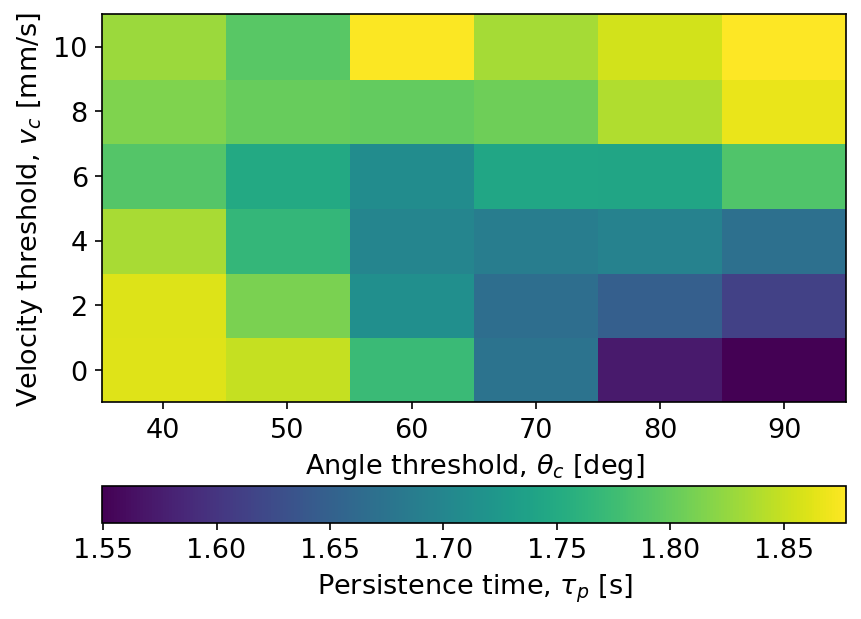

In [75]:
uniqueThetaArr = np.unique(thetaArr) * 180 / np.pi
uniqueVArr = np.unique(velocityThresholdArr)

theoreticalPersistence = 1 / (meanDR + 1/meanTau * (1 - iv(1, meanSigma) / iv(0, meanSigma)))

persistenceMatrix = theoreticalPersistence.reshape((len(uniqueThetaArr), len(uniqueVArr)))

fig, ax = plt.subplots()

pc = ax.pcolor(uniqueThetaArr, uniqueVArr, persistenceMatrix.T, cmap=colormaps[0], rasterized=True)
fig.colorbar(pc, orientation='horizontal', label='Persistence time, $\\tau_p$ [s]')
#ax[1,0].set_xticks([0, 10, 20, 30, 40])
#ax[1,0].set_yticks(uniqueVArr)
ax.set_xlabel('Angle threshold, $\\theta_c$ [deg]')
ax.set_ylabel('Velocity threshold, $v_c$ [mm/s]')
#fig.colorbar(pc)
plt.show()

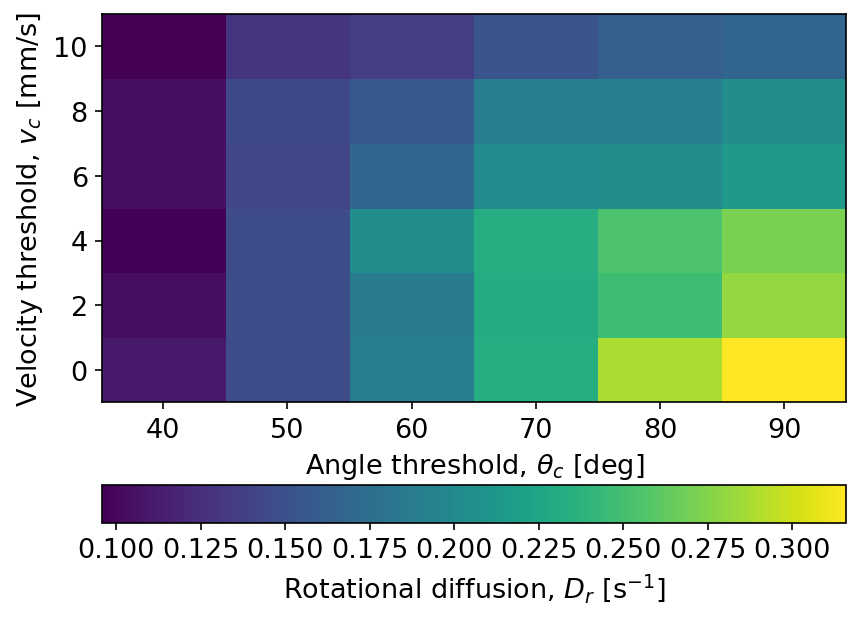

In [69]:
uniqueThetaArr = np.unique(thetaArr) * 180 / np.pi
uniqueVArr = np.unique(velocityThresholdArr)

persistenceMatrix = meanDR.reshape((len(uniqueThetaArr), len(uniqueVArr)))

fig, ax = plt.subplots()

pc = ax.pcolor(uniqueThetaArr, uniqueVArr, persistenceMatrix.T, cmap=colormaps[0], rasterized=True)
fig.colorbar(pc, orientation='horizontal', label='Rotational diffusion, $D_r$ [s$^{-1}$]')
#ax[1,0].set_xticks([0, 10, 20, 30, 40])
#ax[1,0].set_yticks(uniqueVArr)
ax.set_xlabel('Angle threshold, $\\theta_c$ [deg]')
ax.set_ylabel('Velocity threshold, $v_c$ [mm/s]')
#fig.colorbar(pc)
plt.show()